In [2]:
from yfinance import download
from numpy import where, nan
from pandas import isna
from sklearn.tree import DecisionTreeClassifier
from graficos import *
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from datetime import datetime
from warnings import filterwarnings
filterwarnings('ignore')

# PREDIÇÃO DE DADOS BINÁRIOS

Predição da série dos retornos de ativos financeiros

### Dados

In [3]:
ticker = 'AZUL4.SA'
start = '2017-05-12'
end = '2023-05-12'
column_variacao_percentual = 'Adj Close'
periodos_alvo = 1

In [4]:
df_price = download(ticker, period='max', progress=False)
df_price

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA
Date,,,,,,
2017-04-11,22.400000,22.400000,22.980000,21.770000,21.809999,13060500
2017-04-12,22.959999,22.959999,22.990000,22.299999,22.450001,1745900
2017-04-13,22.990000,22.990000,23.010000,22.549999,22.969999,549600
2017-04-17,22.850000,22.850000,23.000000,22.620001,23.000000,249300
2017-04-18,23.910000,23.910000,24.790001,22.600000,22.820000,1125100
...,...,...,...,...,...,...
2024-11-14,5.330000,5.330000,5.530000,5.100000,5.140000,22253100
2024-11-18,4.930000,4.930000,5.350000,4.910000,5.340000,21425400


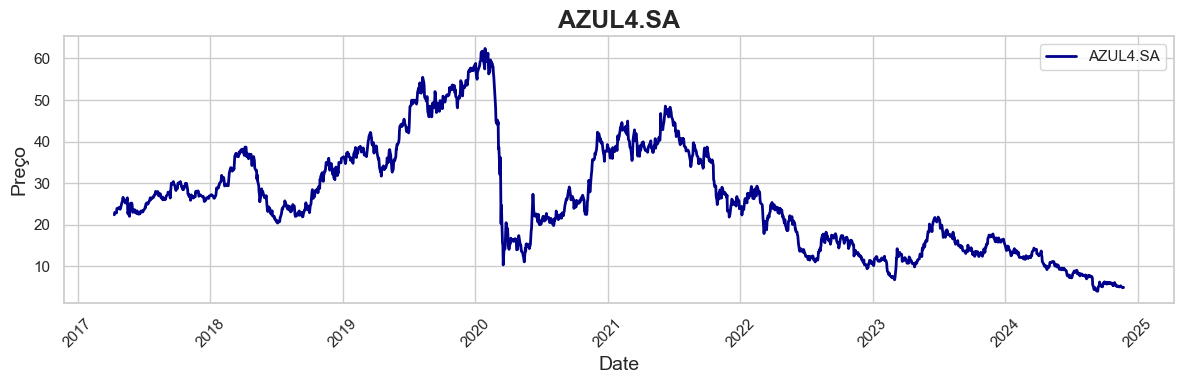

In [5]:
grafico_linha(df_price, 'Adj Close', ticker, 'Date', 'Preço', ticker, (12, 4))

A ``variação percentual`` será utilizada para derivar variáveis de entrada que alimentam o modelo de aprendizado de máquina, auxiliando na identificação de padrões nos dados.

![alt text](Screenshot_1.png)

In [6]:
df_price['variacao_percentual'] = df_price[column_variacao_percentual].pct_change(periodos_alvo)
df_price.tail(2)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,
Date,,,,,,,
2024-11-21,4.86,4.86,5.00,4.83,4.9,18954200,-0.008163
2024-11-22,4.97,4.97,4.98,4.83,4.9,14710300,0.022634


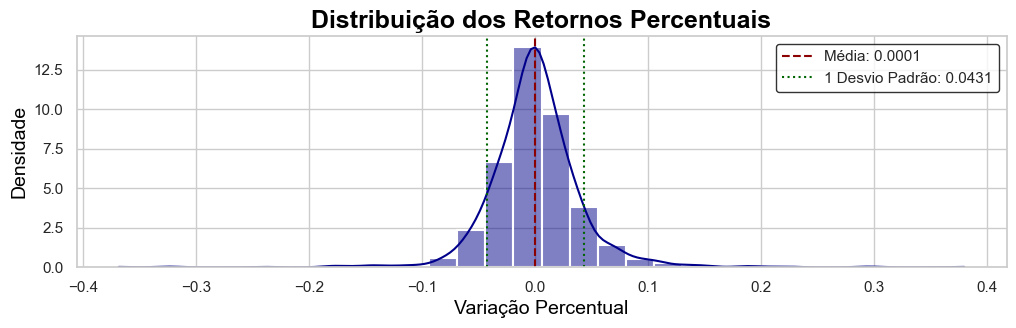

In [7]:
grafico_KDE(df_price, 'variacao_percentual', title='Distribuição dos Retornos Percentuais', xlabel='Variação Percentual')

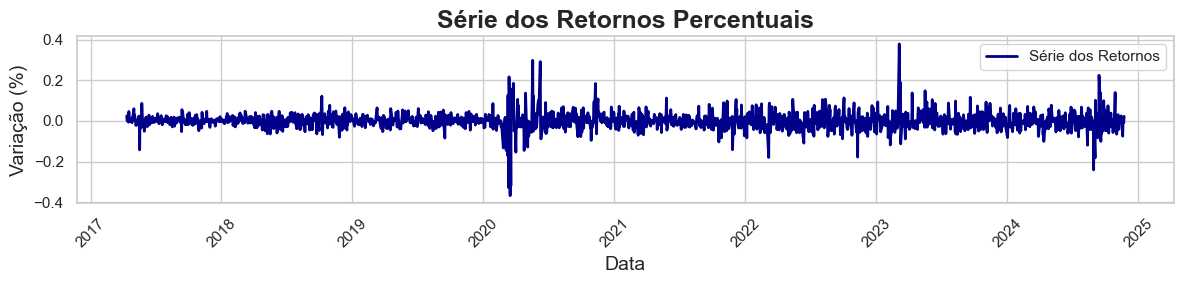

In [8]:
grafico_linha(df_price, 'variacao_percentual', 'Série dos Retornos Percentuais', 'Data', 'Variação (%)', label='Série dos Retornos')

Estou criando uma nova variável, `'alvo_numerico'`, que representa a diferença entre o preço de fechamento e o de abertura. Em seguida, desloca essa coluna para cima, preparando os dados para um modelo que utilizará a variação futura como "alvo" (o que o modelo tentará prever).

O último dado da coluna `'alvo_numerico'` é `NaN`, pois não existe um valor referente ao próximo dia para realizar o deslocamento.

In [9]:
df_price['alvo_numerico'] = df_price['Close'] - df_price['Open']
df_price['alvo_numerico'] = df_price['alvo_numerico'].shift(-periodos_alvo)
df_price.tail(3)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,,
Date,,,,,,,,
2024-11-19,4.90,4.90,5.05,4.86,4.98,17820700,-0.006085,-0.04
2024-11-21,4.86,4.86,5.00,4.83,4.90,18954200,-0.008163,0.07
2024-11-22,4.97,4.97,4.98,4.83,4.90,14710300,0.022634,NaN


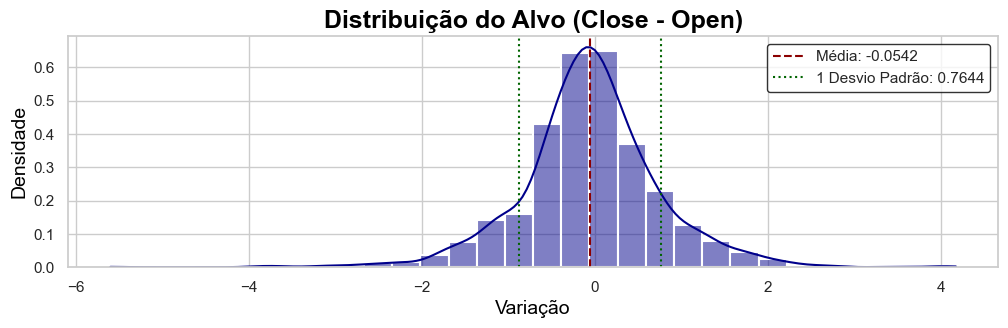

In [10]:
grafico_KDE(df_price, 'alvo_numerico', title='Distribuição do Alvo (Close - Open)', xlabel='Variação')

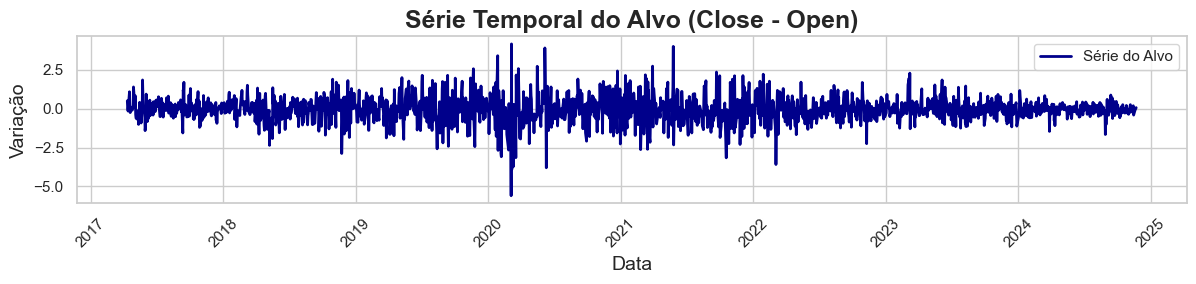

In [11]:
grafico_linha(df_price, 'alvo_numerico', title='Série Temporal do Alvo (Close - Open)', xlabel='Data', ylabel='Variação', label='Série do Alvo')

Ou seja, a previsão é realizada com base nos dados do dia anterior, e o alvo será o preço de fechamento do dia seguinte.



In [12]:
df_alvo_explicativo = df_price.copy()
df_alvo_explicativo = df_alvo_explicativo.reset_index()
df_alvo_explicativo['Date'] = df_alvo_explicativo['Date'].astype(str)
df_alvo_explicativo['variacao_numerica'] = df_alvo_explicativo['Close'] - df_alvo_explicativo['Open']
df_alvo_explicativo['alvo_numerico_e_data'] = (df_alvo_explicativo['variacao_numerica'].astype(str) + ' | ' + df_alvo_explicativo['Date'])
df_alvo_explicativo['alvo_numerico_e_data'] = df_alvo_explicativo['alvo_numerico_e_data'].shift(-periodos_alvo)
df_alvo_explicativo[['Date', 'Open', 'Close', 'variacao_percentual', 'alvo_numerico', 'alvo_numerico_e_data']].tail(3)


Price,Date,Open,Close,variacao_percentual,alvo_numerico,alvo_numerico_e_data
Ticker,,AZUL4.SA,AZUL4.SA,,,
1897,2024-11-19,4.98,4.90,-0.006085,-0.04,-0.039999961853027344 | 2024-11-21
1898,2024-11-21,4.90,4.86,-0.008163,0.07,0.06999969482421875 | 2024-11-22
1899,2024-11-22,4.90,4.97,0.022634,NaN,None


O cálculo do retorno real será feito com base na diferença entre o preço de abertura (Open) e o preço de fechamento (Close), em vez de utilizar a variação percentual.

Quando o valor de `alvo_numerico` para o próximo dia é `NaN` (por exemplo, quando não há dados disponíveis para o dia seguinte), eu considero que a previsão não é válida. Nesse caso, eu também defino o valor de `alvo_binario` como `NaN`, pois a previsão não pode ser feita adequadamente.

Se eu não fizer essa alteração, ao calcular o retorno real, o valor `NaN` no `np.where()` será considerado como `0`, o que pode gerar uma previsão errada ou inválida.

In [13]:
df_price['alvo_binario'] = where(df_price['alvo_numerico'] > 0, 1, 0)

if isna(df_price.iloc[-1, df_price.columns.get_loc('alvo_numerico')]).item():
    df_price.iloc[-1, df_price.columns.get_loc('alvo_numerico')] = nan
    df_price.iloc[-1, df_price.columns.get_loc('alvo_binario')] = nan

df_price.tail(3)

Price,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario
Ticker,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,AZUL4.SA,,,
Date,,,,,,,,,
2024-11-19,4.90,4.90,5.05,4.86,4.98,17820700,-0.006085,-0.04,0.0
2024-11-21,4.86,4.86,5.00,4.83,4.90,18954200,-0.008163,0.07,1.0
2024-11-22,4.97,4.97,4.98,4.83,4.90,14710300,0.022634,NaN,NaN


In [14]:
df_price['alvo_binario'].value_counts()

alvo_binario
0.0    1052
1.0     847
Name: count, dtype: int64

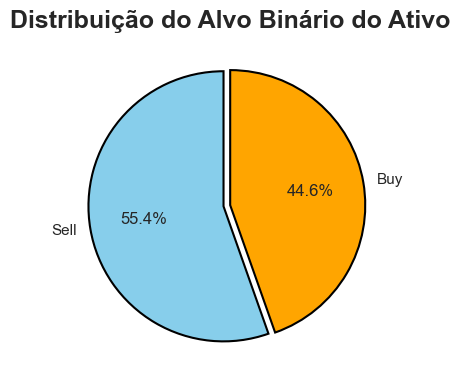

In [15]:
grafico_sinais(df_price, 'Distribuição do Alvo Binário do Ativo')

In [16]:
# Removendo o MultiIndex 
df_price.columns = df_price.columns.droplevel(1)
df_price.columns = list(df_price.columns)
df_price.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario
Date,,,,,,,,,
2024-11-19,4.90,4.90,5.05,4.86,4.98,17820700,-0.006085,-0.04,0.0
2024-11-21,4.86,4.86,5.00,4.83,4.90,18954200,-0.008163,0.07,1.0
2024-11-22,4.97,4.97,4.98,4.83,4.90,14710300,0.022634,NaN,NaN


### Features

Variáveis que serão utilizadas como entradas (inputs) para a predição no modelo de aprendizado de máquina.

O objetivo seria gerar um valor (representado por q) que possivelmente sirva como entrada para um modelo de previsão.

In [17]:
def __0__feature_exemplo_(m):
    m = m['variacao_percentual']
    pi = 3.14159265359
    ri = 2.83132302928
    N0 = lambda x, n=2: (x ** 2) ** (1 / n)
    Q = lambda x, t=5: x.rolling(t).std()
    W = lambda x, t=5: x.rolling(t).sum()
    E = lambda x, t=5: x.rolling(t).mean()
    R = lambda x, t=5: x.rolling(t).max()
    T = lambda x, t=5: x.rolling(t).min()
    Y = lambda x, t=5: x.diff() + x.diff().shift(1)
    A = lambda x, t=5: Q(x.diff(), 17) / (abs(T(x, t)) + E(abs(T(x, 10)).shift(t), t)) # <
    S = lambda x, t=5: W(W(Q(x.diff())) - (pi * R(x.diff(), 11)).shift(t), 19) / W(abs(Y(x) * x.diff().shift(1)) * E(x, 17)) # <
    D = lambda x, t=5: W(Y(m) * ri) - W(Q(Y(m))) / W((1/2*E(Y(m))) - W(abs(1 - m.diff() * T(m).shift(t))))
    Z = lambda x, t=5: (1/10*((A(x, 17) - W((A(x, 2) + A(x, 17).shift(3))).diff()) * m)) - (1/16*m)
    X = lambda x, t=5: ((ri*S(x, t)) - (1/2*(Y(Q(Z(x, 2))) * S(x, 2)))) / W((1-N0(Z(x, 13), 2)) - ((1/W(A(x, 6), 7)) * R(A(x, 3), 11)))
    p = 1/T((D(m)*ri/Q(Z(m),12)) / (((X(m) * E(E(m).diff()).diff()) * A(m)) * D(m)))
    o = (W(Y(E((m / A(p, 17)) * Y(m), 18)) * Z(m) * X(m), 3).diff() * m) - m
    return o

df_price[0] = __0__feature_exemplo_(df_price)

df_price.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0
Date,,,,,,,,,,
2024-11-19,4.90,4.90,5.05,4.86,4.98,17820700,-0.006085,-0.04,0.0,0.006055
2024-11-21,4.86,4.86,5.00,4.83,4.90,18954200,-0.008163,0.07,1.0,0.008452
2024-11-22,4.97,4.97,4.98,4.83,4.90,14710300,0.022634,NaN,NaN,-0.022742


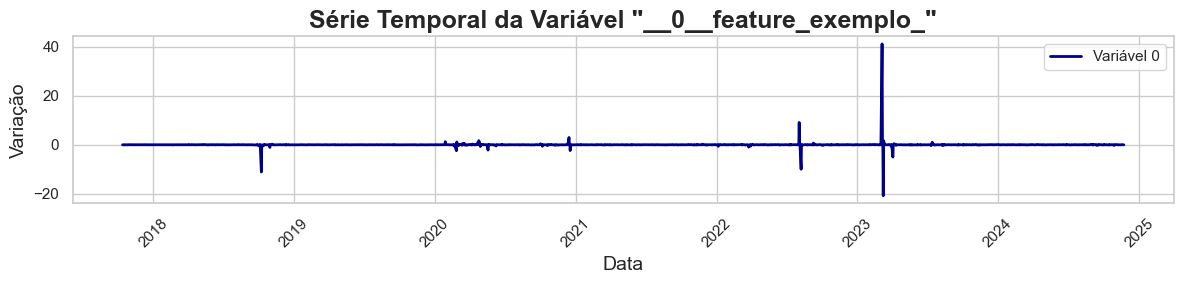

In [18]:
grafico_linha(df_price, 0, title='Série Temporal da Variável "__0__feature_exemplo_"', xlabel='Data', ylabel='Variação', label='Variável 0')

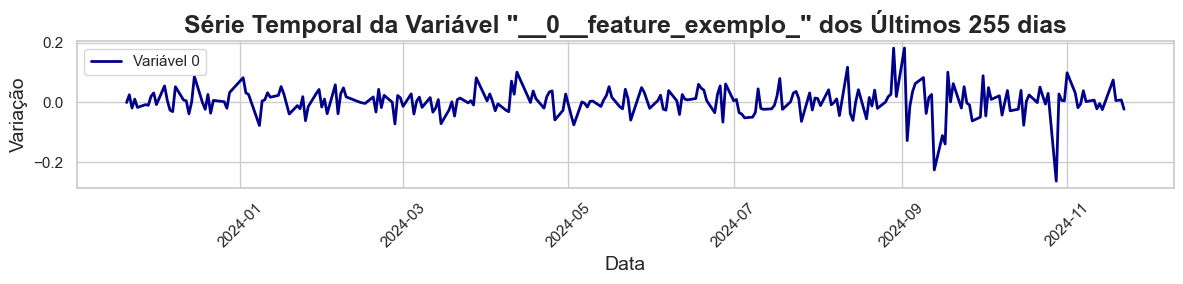

In [19]:
grafico_linha(df_price.tail(255), 0, title='Série Temporal da Variável "__0__feature_exemplo_" dos Últimos 255 dias', xlabel='Data', ylabel='Variação', label='Variável 0')

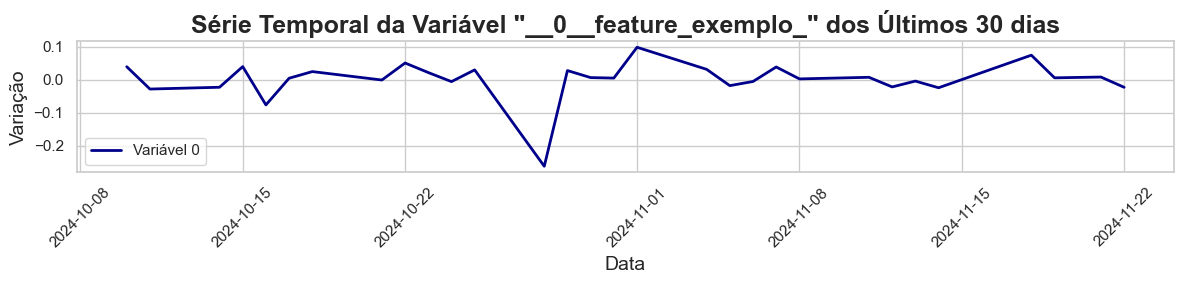

In [20]:
grafico_linha(df_price.tail(30), 0, title='Série Temporal da Variável "__0__feature_exemplo_" dos Últimos 30 dias', xlabel='Data', ylabel='Variação', label='Variável 0')

In [21]:
df_price[0].describe()

count    1770.000000
mean        0.003248
std         1.193830
min       -20.869533
25%        -0.019833
50%         0.000797
75%         0.021331
max        41.230773
Name: 0, dtype: float64

In [22]:
print('Quantidade de Dados Perdidos da Variável 0: ', int(df_price[0].isnull().sum()))

Quantidade de Dados Perdidos da Variável 0:  130


### Separando a base de dados em 50% treino e teste

In [23]:
df_price_treino_e_teste = df_price.loc[datetime.strptime(start, '%Y-%m-%d'): datetime.strptime(end, '%Y-%m-%d')]
df_price_treino_e_teste

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0
Date,,,,,,,,,,
2017-05-12,25.250000,25.250000,25.790001,24.900000,25.790001,155600,0.000000,-1.010000,0.0,NaN
2017-05-15,25.680000,25.680000,26.690001,25.360001,26.690001,1205200,0.017030,0.410000,1.0,NaN
2017-05-16,26.299999,26.299999,26.299999,25.700001,25.889999,768700,0.024143,0.160000,1.0,NaN
2017-05-17,26.500000,26.500000,26.900000,26.000000,26.340000,1085600,0.007605,-0.280001,0.0,NaN
2017-05-18,22.719999,22.719999,24.139999,21.760000,23.000000,829700,-0.142642,-0.610001,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-05-08,11.720000,11.720000,12.110000,11.650000,11.710000,9554900,0.007739,0.100000,1.0,-0.008869
2023-05-09,11.770000,11.770000,11.990000,11.570000,11.670000,11598000,0.004266,0.540000,1.0,-0.004262
2023-05-10,12.290000,12.290000,12.330000,11.750000,11.750000,15418500,0.044180,0.660000,1.0,-0.036728


In [24]:
split_index = round(len(df_price_treino_e_teste) * 0.50)
dados_treino = df_price_treino_e_teste.iloc[:split_index].dropna()
dados_teste = df_price_treino_e_teste.iloc[split_index:].dropna() # <-!
dados_pos_teste = df_price.loc[datetime.strptime(end, '%Y-%m-%d'):].dropna()

In [25]:
dados_treino.head(2)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0
Date,,,,,,,,,,
2017-10-13,29.200001,29.200001,29.889999,29.02,29.889999,409800,-0.021776,-0.400002,0.0,-0.024026
2017-10-16,28.709999,28.709999,29.270000,27.76,29.110001,870200,-0.016781,-0.049999,0.0,0.019301


In [26]:
dados_teste.head(2)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0
Date,,,,,,,,,,
2020-05-12,12.53,12.53,13.79,12.53,13.25,7660600,-0.047148,-0.57,0.0,0.040572
2020-05-13,12.29,12.29,13.02,12.08,12.86,9519100,-0.019154,-0.40,0.0,0.019179


In [27]:
dados_pos_teste.head(2)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0
Date,,,,,,,,,,
2023-05-12,12.86,12.86,13.14,12.62,12.97,17979700,-0.008481,-0.3,0.0,0.008684
2023-05-15,12.76,12.76,13.09,11.35,13.06,32580300,-0.007776,-0.3,0.0,0.008924


Dados treino

In [28]:
print(f'Start: {str(dados_treino.index[0])[:10]}')
print(f'End: {str(dados_treino.index[-1])[:10]}')
print(f'Quantidade de Dados: {len(dados_treino)}')

Start: 2017-10-13
End: 2020-05-11
Quantidade de Dados: 638


Dados teste

In [29]:
print(f'Start: {str(dados_teste.index[0])[:10]}')
print(f'End: {str(dados_teste.index[-1])[:10]}')
print(f'Quantidade de Dados: {len(dados_teste)}')

Start: 2020-05-12
End: 2023-05-12
Quantidade de Dados: 747


Dados pos teste

In [30]:
print(f'Start: {str(dados_pos_teste.index[0])[:10]}')
print(f'End: {str(dados_pos_teste.index[-1])[:10]}')
print(f'Quantidade de Dados: {len(dados_pos_teste)}')

Start: 2023-05-12
End: 2024-11-21
Quantidade de Dados: 385


### Predição

In [31]:
# Nome da coluna
features = [0]

x_treino = dados_treino[features]
y_treino = dados_treino['alvo_binario']

x_teste = dados_teste[features]
y_teste = dados_teste['alvo_binario']

x_pos_teste = dados_pos_teste[features]
y_pos_teste = dados_pos_teste['alvo_binario']

decision_tree_classifier = DecisionTreeClassifier(criterion='gini', max_depth=3)

decision_tree_classifier.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=3)

In [32]:
y_predicao_treino = decision_tree_classifier.predict(x_treino)
y_predicao_teste = decision_tree_classifier.predict(x_teste)
y_predicao_pos_teste = decision_tree_classifier.predict(x_pos_teste)

dados_treino['predicao'] = y_predicao_treino
dados_teste['predicao'] = y_predicao_teste
dados_pos_teste['predicao'] = y_predicao_pos_teste

### Resultados

In [33]:
dados_treino['predicao'].value_counts()

predicao
0.0    476
1.0    162
Name: count, dtype: int64

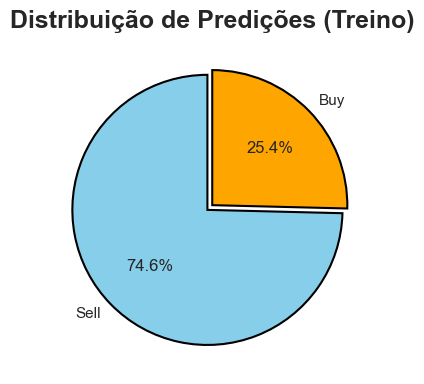

In [34]:
grafico_sinais(dados_treino, 'Distribuição de Predições (Treino)')

In [35]:
dados_teste['predicao'].value_counts()

predicao
0.0    509
1.0    238
Name: count, dtype: int64

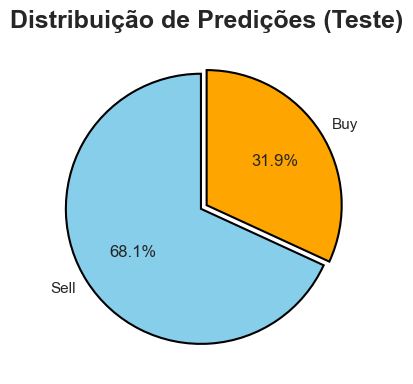

In [36]:
grafico_sinais(dados_teste, 'Distribuição de Predições (Teste)')

In [37]:
dados_pos_teste['predicao'].value_counts()

predicao
0.0    267
1.0    118
Name: count, dtype: int64

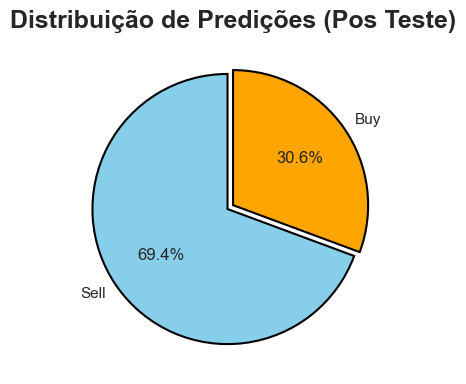

In [38]:
grafico_sinais(dados_pos_teste, 'Distribuição de Predições (Pos Teste)')

In [39]:
def calcula_resultado(dados):
    resultado = []
    for predicao, alvo, alvo_numerico in list(dados[['predicao', 'alvo_binario', 'alvo_numerico']].values):
        if predicao == alvo:
            resultado.append(abs(alvo_numerico))
        else:
            resultado.append(-abs(alvo_numerico))
    dados['serie_retorno'] = resultado
    return dados

In [40]:
# Definindo a quantidade de contratos
quantidade_de_contratos = 100

In [41]:
dados_treino = calcula_resultado(dados_treino)
dados_treino['retorno_acumulado'] = dados_treino['serie_retorno'].cumsum() * quantidade_de_contratos
dados_treino.head(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0,predicao,serie_retorno,retorno_acumulado
Date,,,,,,,,,,,,,
2017-10-13,29.200001,29.200001,29.889999,29.020000,29.889999,409800,-0.021776,-0.400002,0.0,-0.024026,1.0,-0.400002,-40.000153
2017-10-16,28.709999,28.709999,29.270000,27.760000,29.110001,870200,-0.016781,-0.049999,0.0,0.019301,0.0,0.049999,-35.000229
2017-10-17,28.450001,28.450001,28.629999,28.049999,28.500000,445400,-0.009056,0.320000,1.0,0.009108,0.0,-0.320000,-67.000198


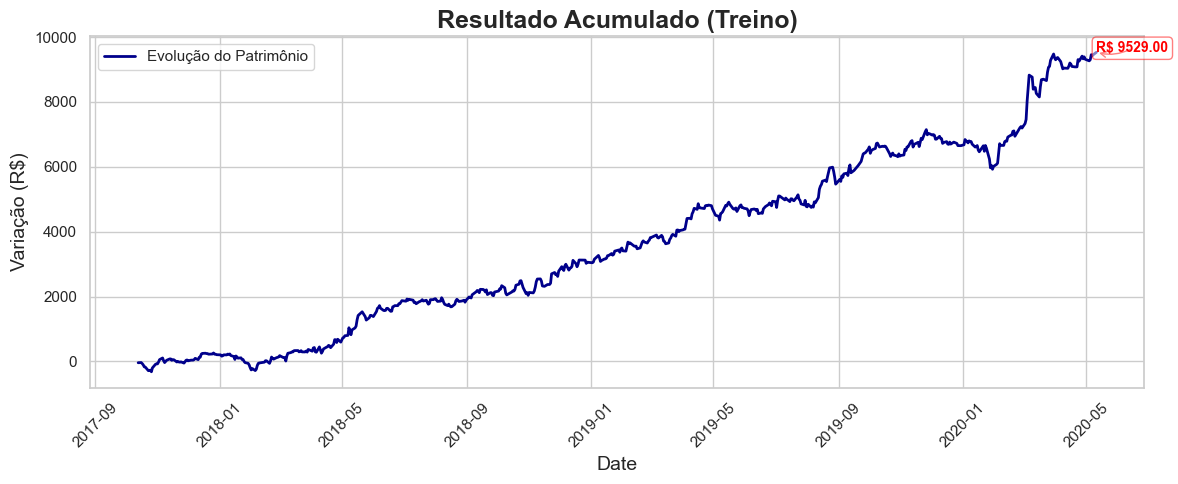

In [42]:
grafico_retorno(dados_treino, 'retorno_acumulado', 'Resultado Acumulado (Treino)', 'Date', 'Variação (R$)', 'Evolução do Patrimônio', figsize=(12, 5))

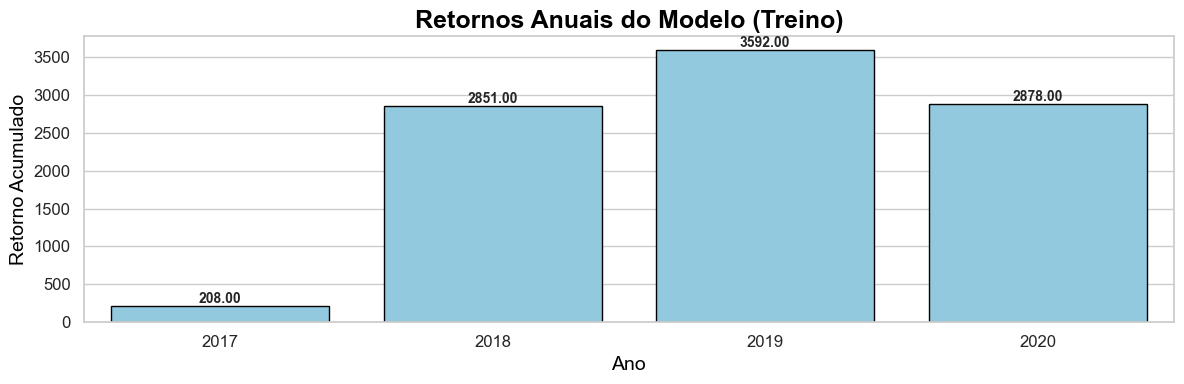

In [43]:
grafico_retorno_anual(dados_treino, 'serie_retorno', 'Retornos Anuais do Modelo (Treino)', quantidade_de_contratos=quantidade_de_contratos)

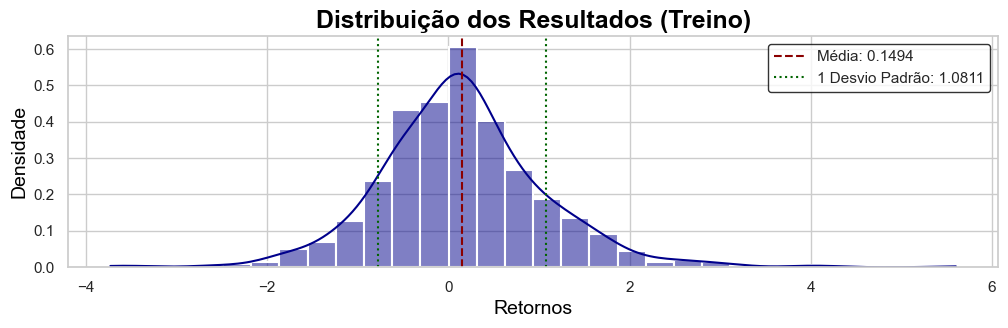

In [44]:
grafico_KDE(dados_treino, 'serie_retorno', 'Distribuição dos Resultados (Treino)', 'Retornos')

In [45]:
dados_teste = calcula_resultado(dados_teste)
dados_teste['retorno_acumulado'] = dados_teste['serie_retorno'].cumsum() * quantidade_de_contratos
dados_teste.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0,predicao,serie_retorno,retorno_acumulado
Date,,,,,,,,,,,,,
2023-05-10,12.29,12.29,12.33,11.75,11.75,15418500,0.044180,0.660000,1.0,-0.036728,1.0,0.660000,5238.003302
2023-05-11,12.97,12.97,13.03,12.25,12.31,18203600,0.055330,-0.110001,0.0,-0.045268,1.0,-0.110001,5227.003241
2023-05-12,12.86,12.86,13.14,12.62,12.97,17979700,-0.008481,-0.300000,0.0,0.008684,0.0,0.300000,5257.003260


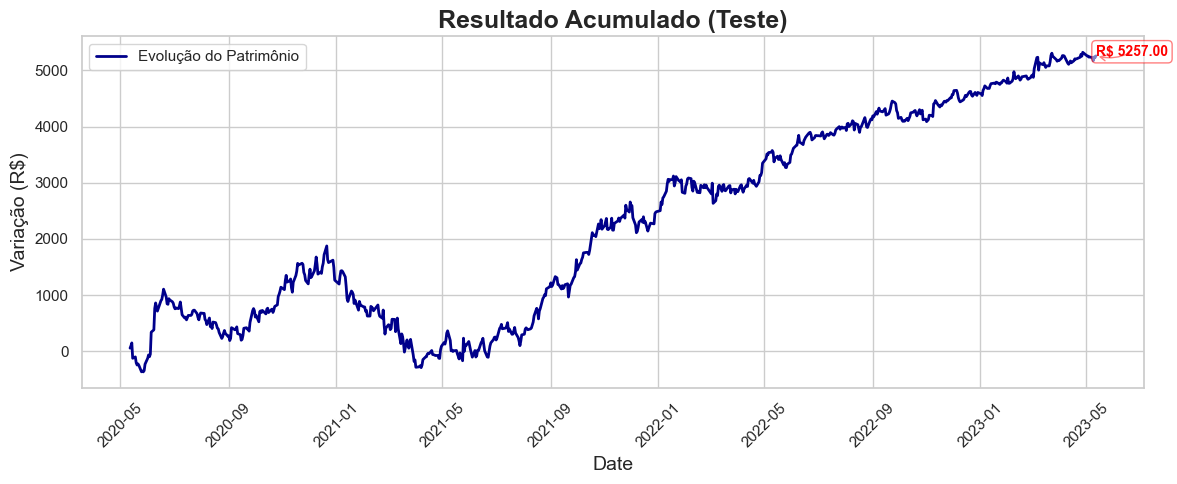

In [46]:
grafico_retorno(dados_teste, 'retorno_acumulado', 'Resultado Acumulado (Teste)', 'Date', 'Variação (R$)', 'Evolução do Patrimônio', figsize=(12, 5))

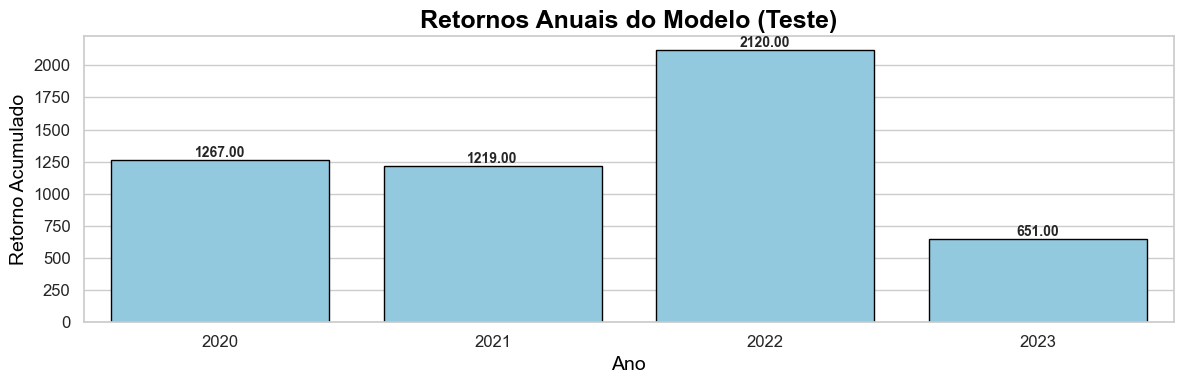

In [47]:
grafico_retorno_anual(dados_teste, 'serie_retorno', 'Retornos Anuais do Modelo (Teste)', quantidade_de_contratos=quantidade_de_contratos)

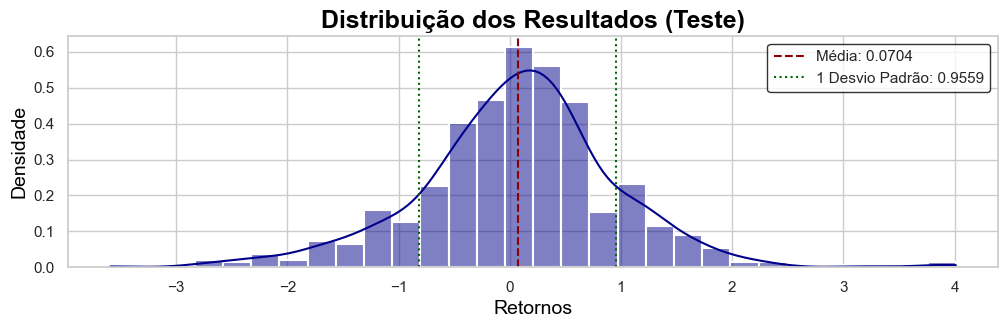

In [48]:
grafico_KDE(dados_teste, 'serie_retorno', 'Distribuição dos Resultados (Teste)', 'Retornos')

In [49]:
dados_pos_teste = calcula_resultado(dados_pos_teste)
dados_pos_teste['retorno_acumulado'] = dados_pos_teste['serie_retorno'].cumsum() * quantidade_de_contratos
dados_pos_teste.tail(3)

,Adj Close,Close,High,Low,Open,Volume,variacao_percentual,alvo_numerico,alvo_binario,0,predicao,serie_retorno,retorno_acumulado
Date,,,,,,,,,,,,,
2024-11-18,4.93,4.93,5.35,4.91,5.34,21425400,-0.075047,-0.08,0.0,0.074845,1.0,-0.08,1174.001694
2024-11-19,4.90,4.90,5.05,4.86,4.98,17820700,-0.006085,-0.04,0.0,0.006055,0.0,0.04,1178.001690
2024-11-21,4.86,4.86,5.00,4.83,4.90,18954200,-0.008163,0.07,1.0,0.008452,0.0,-0.07,1171.001720


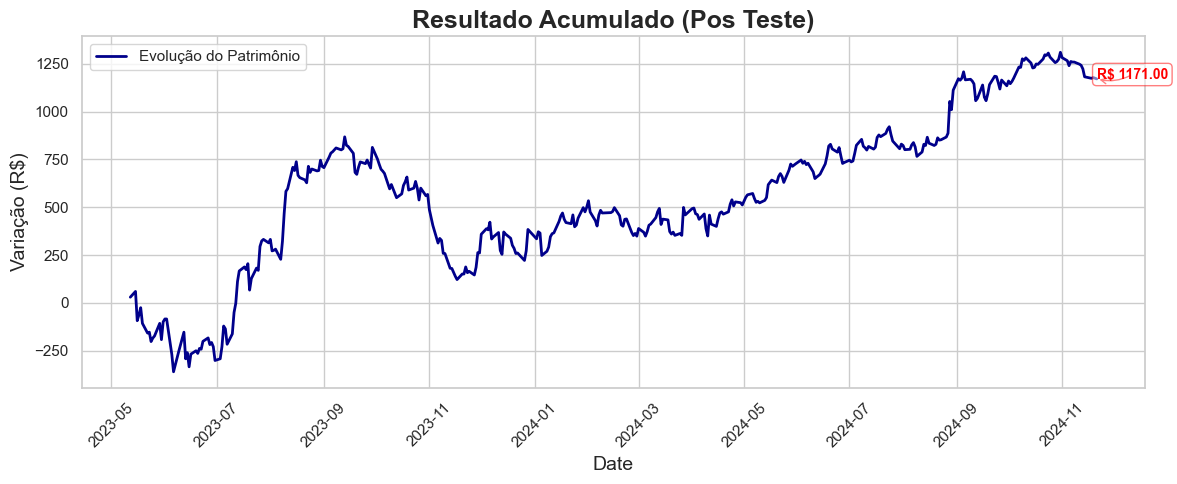

In [50]:
grafico_retorno(dados_pos_teste, 'retorno_acumulado', 'Resultado Acumulado (Pos Teste)', 'Date', 'Variação (R$)', 'Evolução do Patrimônio', figsize=(12, 5))

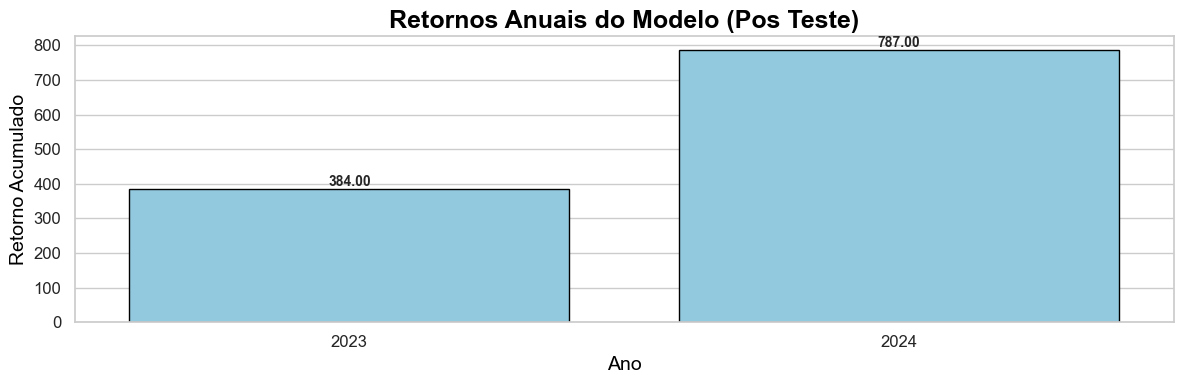

In [51]:
grafico_retorno_anual(dados_pos_teste, 'serie_retorno', 'Retornos Anuais do Modelo (Pos Teste)', quantidade_de_contratos=quantidade_de_contratos)

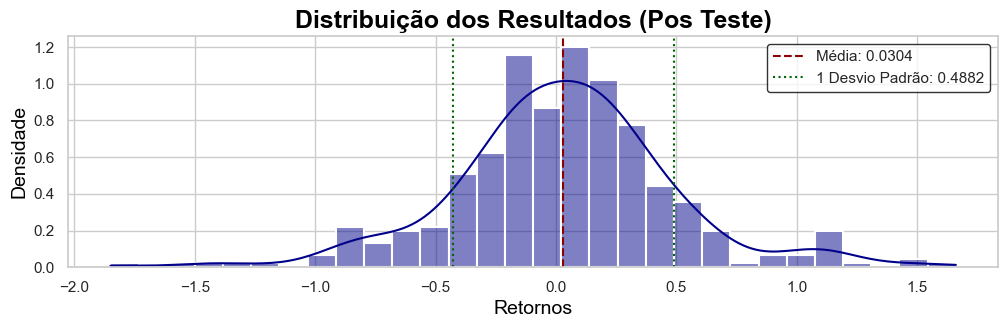

In [52]:
grafico_KDE(dados_pos_teste, 'serie_retorno', 'Distribuição dos Resultados (Pos Teste)', 'Retornos')

### Dados Estatísticos

In [53]:
print(f'Acurácia Treino: {metrics.accuracy_score(y_treino, y_predicao_treino):.3f}')
print(f'Acurácia Teste: {metrics.accuracy_score(y_teste, y_predicao_teste):.3f}')
print()
print(f'Média dos Retornos Diários Treino: R$ {dados_treino["serie_retorno"].mean() * quantidade_de_contratos:.3f}')
print(f'Média dos Retornos Diários Teste: R$ {dados_teste["serie_retorno"].mean() * quantidade_de_contratos:.3f}')

Acurácia Treino: 0.582
Acurácia Teste: 0.562

Média dos Retornos Diários Treino: R$ 14.936
Média dos Retornos Diários Teste: R$ 7.037


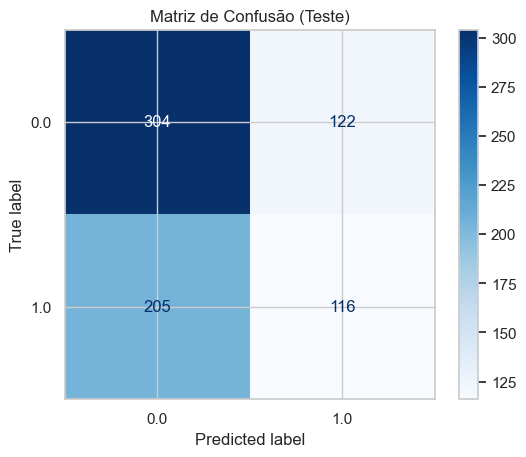

In [54]:
matriz_confusao = confusion_matrix(y_teste, y_predicao_teste)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=decision_tree_classifier.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão (Teste)")
plt.show()

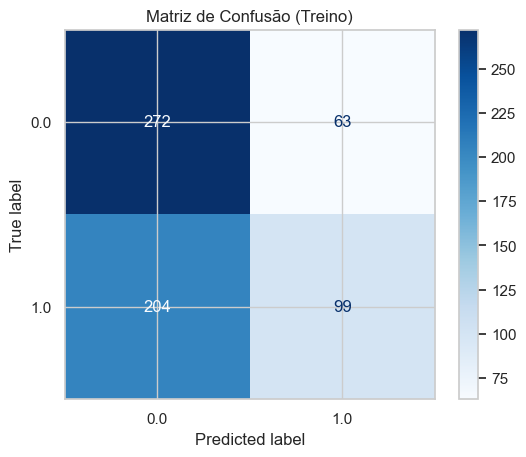

In [55]:
matriz_confusao = confusion_matrix(y_treino, y_predicao_treino)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=decision_tree_classifier.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão (Treino)")
plt.show()

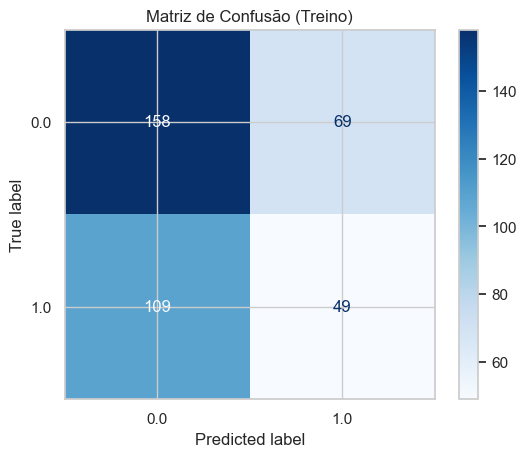

In [56]:
matriz_confusao = confusion_matrix(y_pos_teste, y_predicao_pos_teste)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=decision_tree_classifier.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão (Treino)")
plt.show()

### Classification Report (Treino)

In [57]:
relatorio = classification_report(y_treino, y_predicao_treino)
print(relatorio)

              precision    recall  f1-score   support

         0.0       0.57      0.81      0.67       335
         1.0       0.61      0.33      0.43       303

    accuracy                           0.58       638
   macro avg       0.59      0.57      0.55       638
weighted avg       0.59      0.58      0.55       638



### Classification Report (Teste)

In [58]:
relatorio = classification_report(y_teste, y_predicao_teste)
print(relatorio)

              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65       426
         1.0       0.49      0.36      0.42       321

    accuracy                           0.56       747
   macro avg       0.54      0.54      0.53       747
weighted avg       0.55      0.56      0.55       747



### Classification Report (Pos Treino)

In [59]:
relatorio = classification_report(y_pos_teste, y_predicao_pos_teste)
print(relatorio)

              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64       227
         1.0       0.42      0.31      0.36       158

    accuracy                           0.54       385
   macro avg       0.50      0.50      0.50       385
weighted avg       0.52      0.54      0.52       385



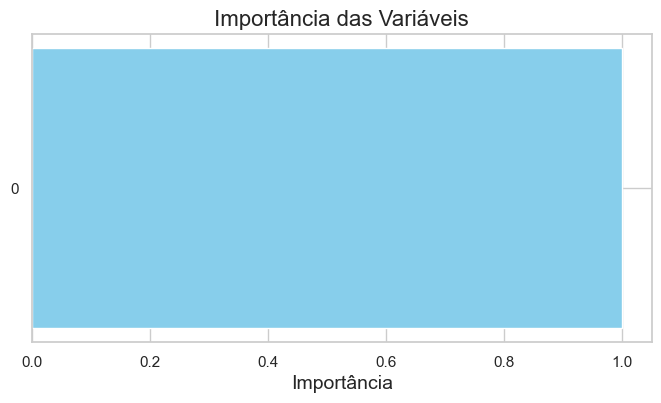

In [60]:
importances = decision_tree_classifier.feature_importances_

plt.figure(figsize=(8, 4))
plt.barh(range(len(features)), importances, color='skyblue')
plt.yticks(range(len(features)), [str(f) for f in features])
plt.xlabel("Importância", fontsize=14)
plt.title("Importância das Variáveis", fontsize=16)
plt.show()


### Avaliando Cenários Sintéticos 